In [146]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import json
import scipy.linalg
import pandas
from PIL import ImageDraw, Image, ImageFont
from mylib import *
from difflib import Differ
from IPython.display import HTML as html_print

<h1>Define Walsh Function Using the formula Walsh Function</h1>
<p> Referance Website :- https://mathworld.wolfram.com/WalshFunction.html</p>

In [147]:
def Hadamard2Walsh(n):
  
   
    from scipy.linalg import hadamard
    from math import log

    hadamardMatrix=hadamard(n)
    HadIdx = np.arange(n)
    M = int(log(n,2))+1

    for i in HadIdx:
        s=format(i, '#032b')
        s=s[::-1]; s=s[:-2]; s=list(s)
        x=[int(x) for x in s]
        x=np.array(x)
        if(i==0):
            binHadIdx=x
        else:
            binHadIdx=np.vstack((binHadIdx,x))

    binSeqIdx = np.zeros((n,M)).T

    for k in reversed(range(1,int(M))):
        tmp=np.bitwise_xor(binHadIdx.T[k],binHadIdx.T[k-1])
        binSeqIdx[k]=tmp

    tmp=np.power(2,np.arange(M)[::-1])
    tmp=tmp.T
    SeqIdx = np.dot(binSeqIdx.T,tmp)

    j=1
    for i in SeqIdx:

        if(j==1):
            walshMatrix=hadamardMatrix[int(i)]
        else:
            walshMatrix=np.vstack((walshMatrix,hadamardMatrix[int(i)]))
        j+=1
        
    return hadamardMatrix,walshMatrix

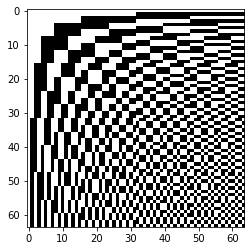

In [148]:
n = 64
(H,W)=Hadamard2Walsh(n)

plt.imshow(W, cmap='gray');

In [149]:
kernels = []

l = int(np.sqrt(W.shape[0]))

for i in range(l):
    subw = np.zeros_like(W)
    subw[:] = W[:,i].copy()
    kernels.append(subw)

    
walsh = []
for i in range(l):
    for j in range(l):
        walsh.append(kernels[i] * kernels[j].T)

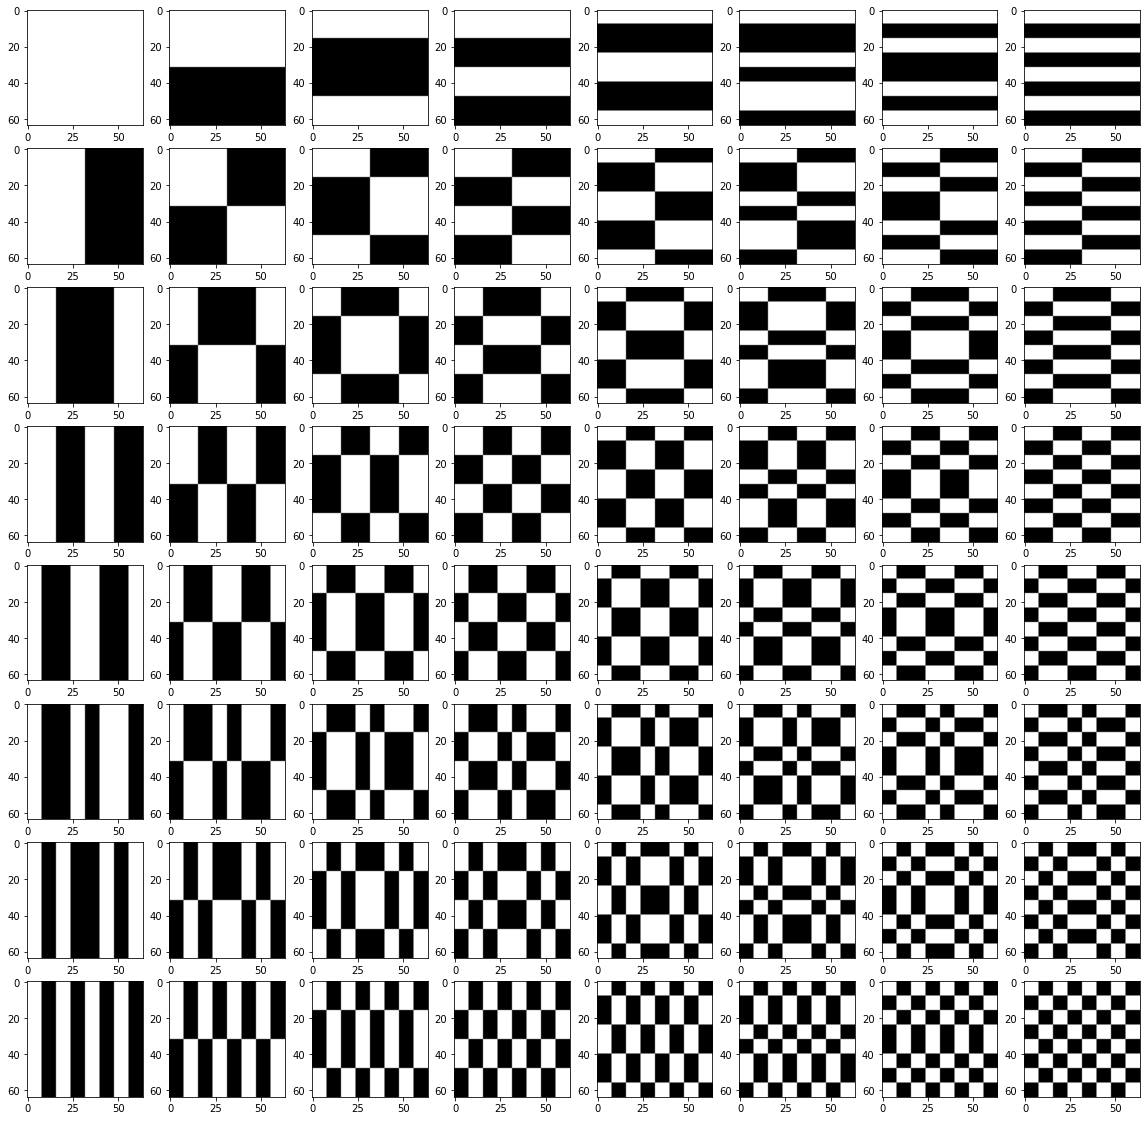

In [150]:
fig, ax = plt.subplots(8,8, figsize=(20,20))
k=0
for i in range(l):
    for j in range(l):
        ax[i,j].imshow(walsh[k], cmap='gray', vmin=-1, vmax=1)
        k+=1

In [151]:
to_save = []
for w in walsh:
    to_save.append(w.tolist())
    
with open("./walsh.json", "w") as f:
    f.write(json.dumps(to_save, indent=2))
    
print("Saved Result")

Saved Result


<h1> Generate blank Image, write the character on it </h1>
<p>Referance:- https://code-maven.com/create-images-with-python-pil-pillow </p>

In [152]:
chars = list(range(ord('A'), ord('Z')+1)) + list(range(ord('a'), ord('z')+1))
chars = [chr(x) for x in chars]
chars += [x for x in '.,!?()[]!@$&1234567890;:\'"']
chars += ['ft','fe','fo'] #characters that are very close to each other

C:\Users\PC Center\Anaconda3\envs\DataLab\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


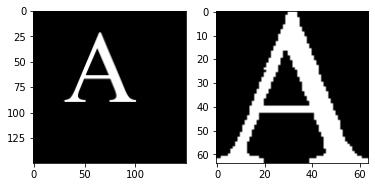

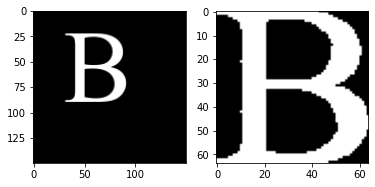

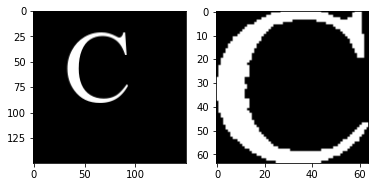

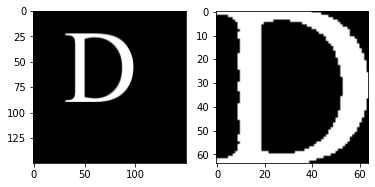

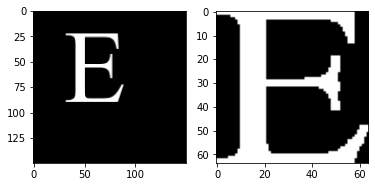

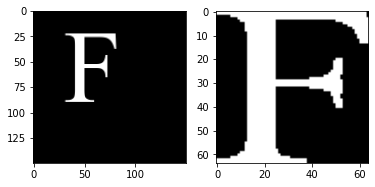

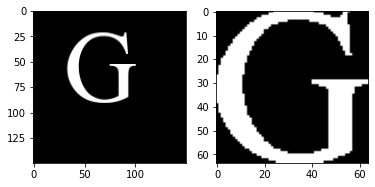

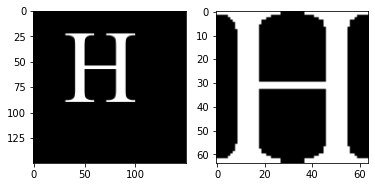

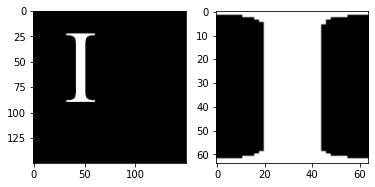

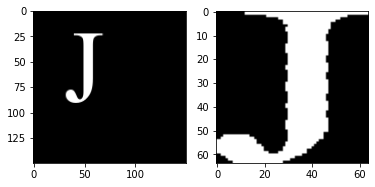

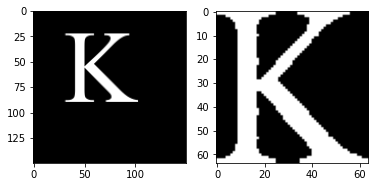

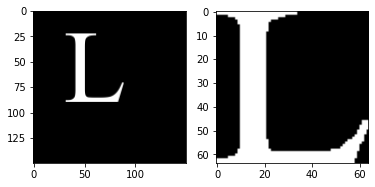

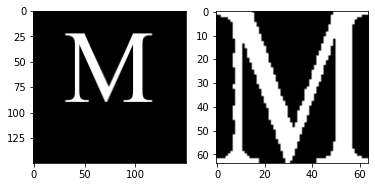

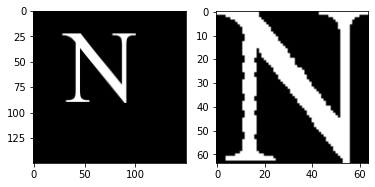

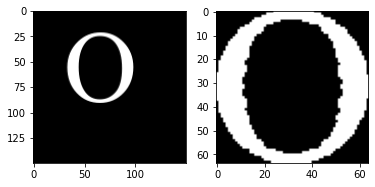

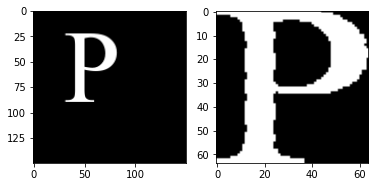

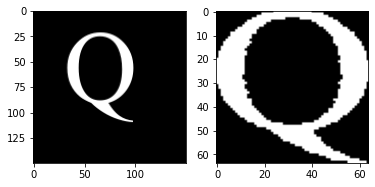

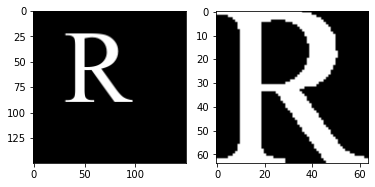

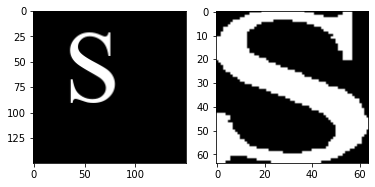

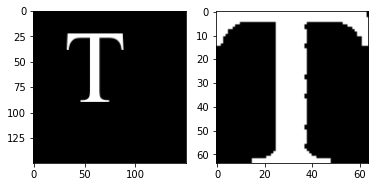

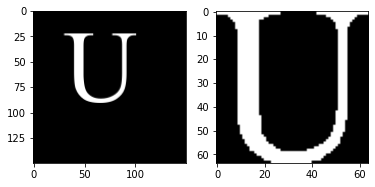

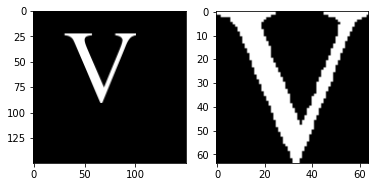

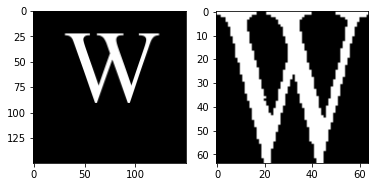

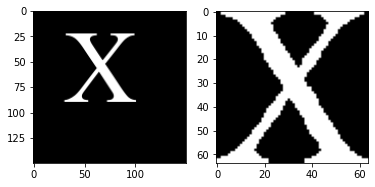

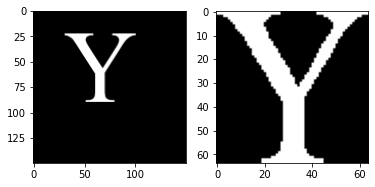

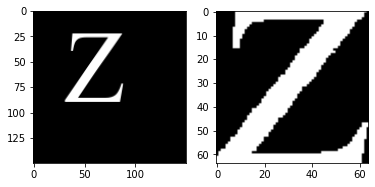

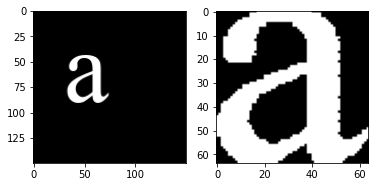

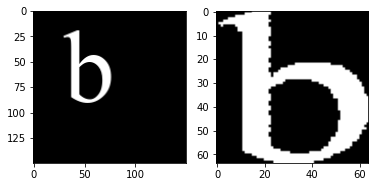

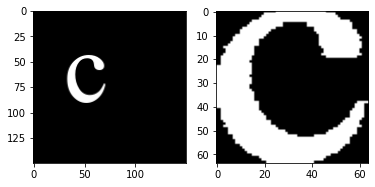

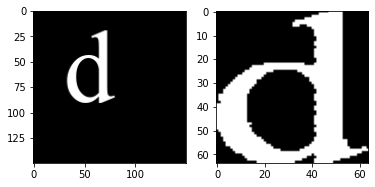

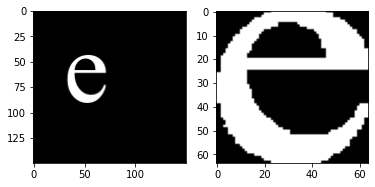

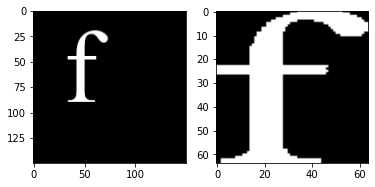

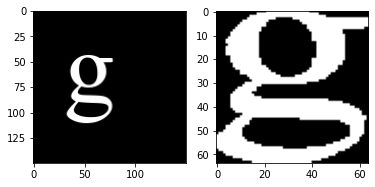

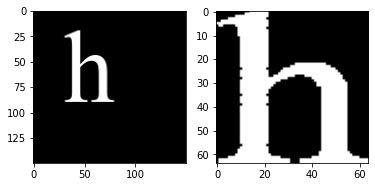

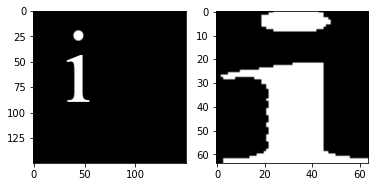

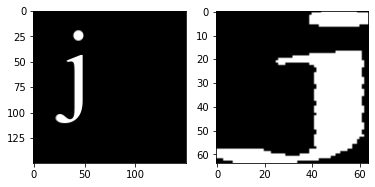

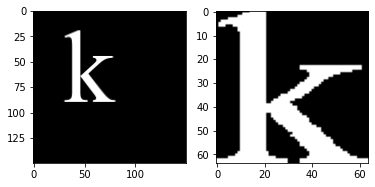

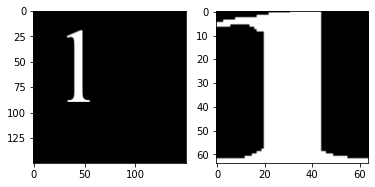

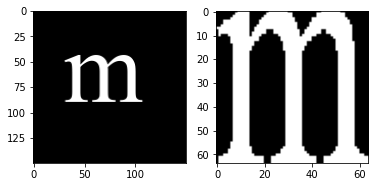

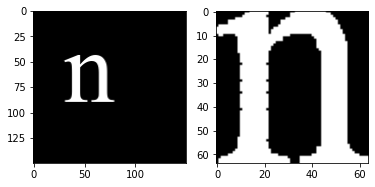

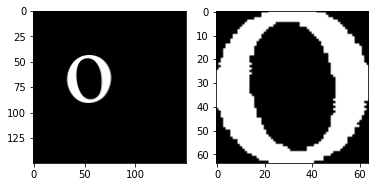

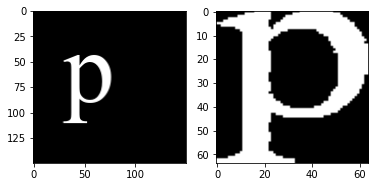

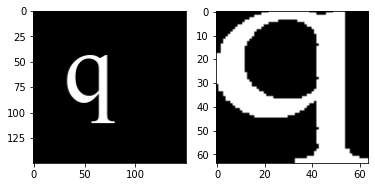

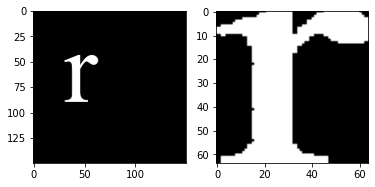

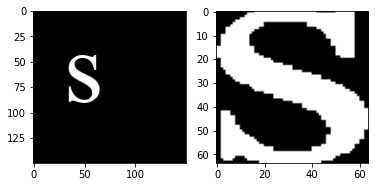

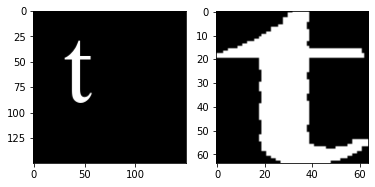

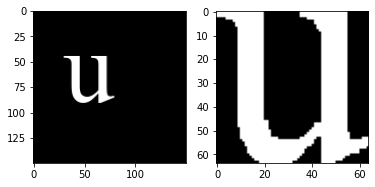

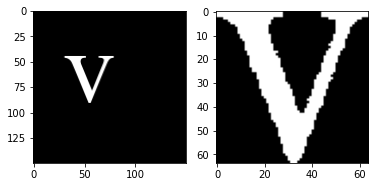

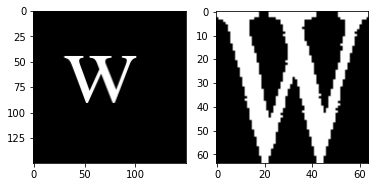

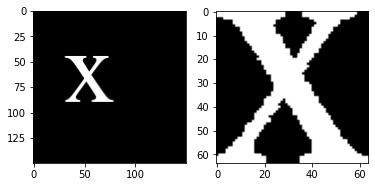

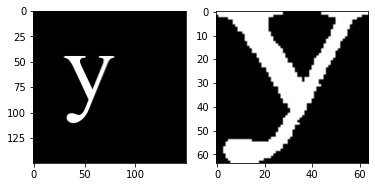

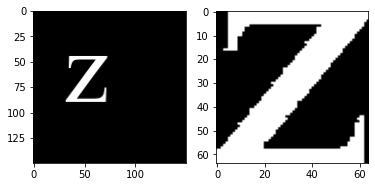

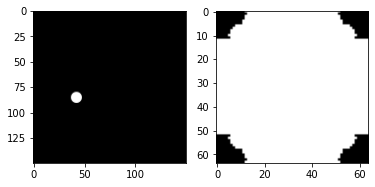

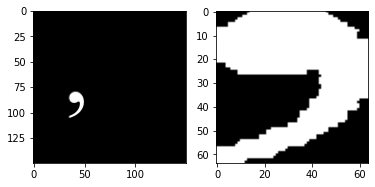

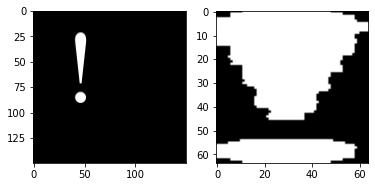

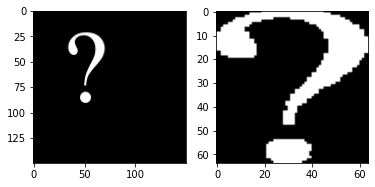

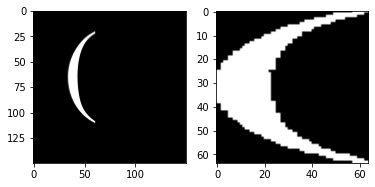

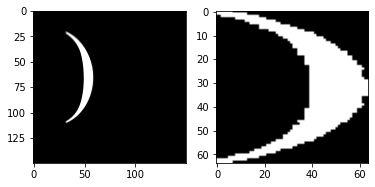

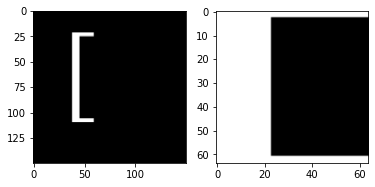

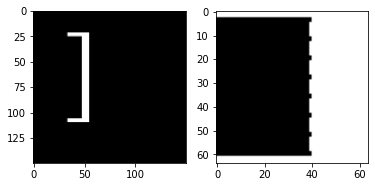

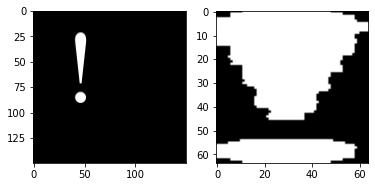

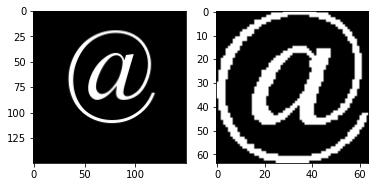

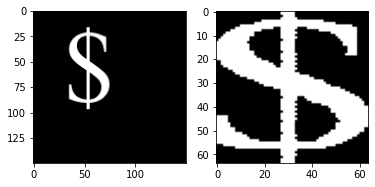

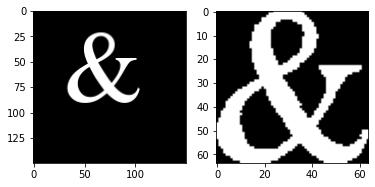

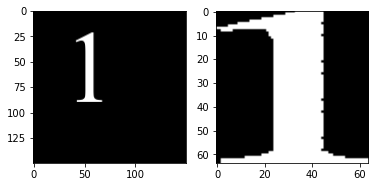

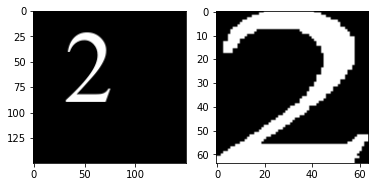

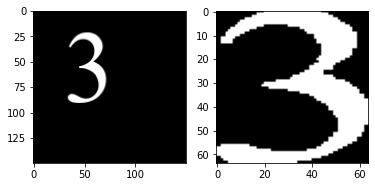

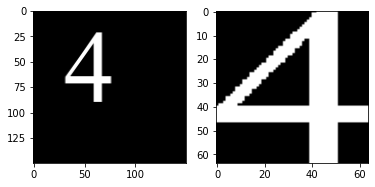

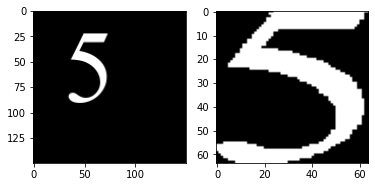

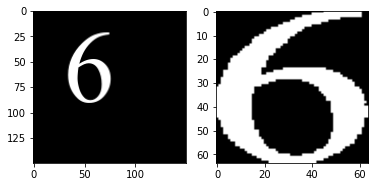

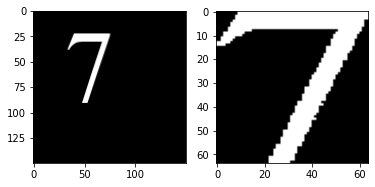

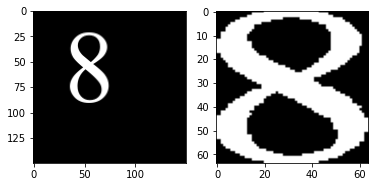

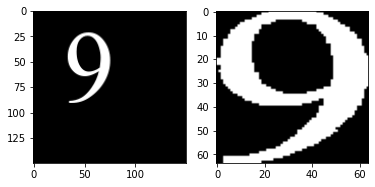

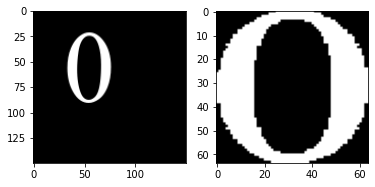

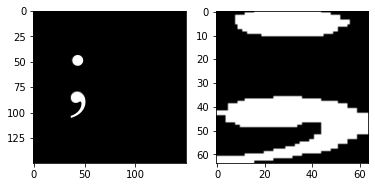

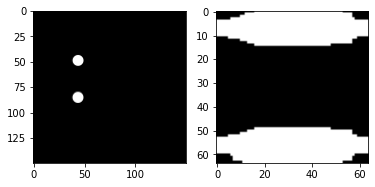

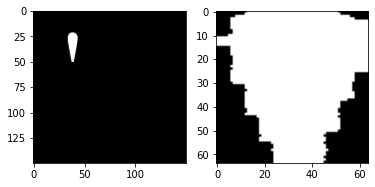

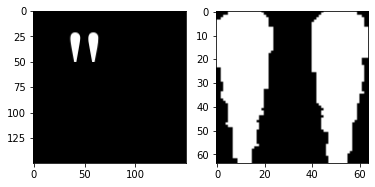

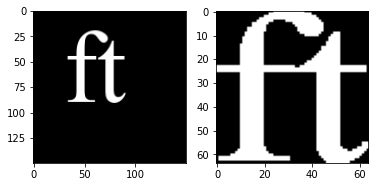

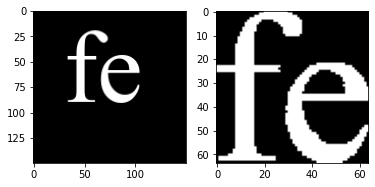

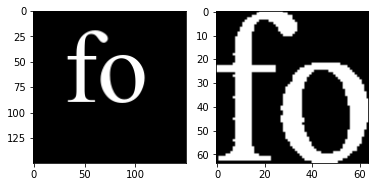

In [153]:
fontsize = 100
img_fraction = 0.5
# # ttf_url = "../fonts-ttf/FreeSans.ttf" #(Ubuntu)
ttf_url = "./times.ttf" #(Windows)
font = ImageFont.truetype(ttf_url, fontsize)
letters = []

for c in chars:
    a = np.zeros([150,150],dtype=np.uint16)
    img = Image.fromarray(a,mode='L')
    draw = ImageDraw.Draw(img)
    txt = c

    fontsize = 100
    font = ImageFont.truetype(ttf_url, fontsize)



    draw.text((30,0), txt, font=font, fill=255)

    thresh = 1
    bw = gray_to_bw(np.array(img), thresh)
    bw = bw // np.max(bw)


    lines_vert = vert_seg(bw)

    lines_hor = hor_seg(bw)

    bw = bw[lines_vert[0]['start']:lines_vert[-1]['end'], lines_hor[0]['start']:lines_hor[-1]['end']]

    bw = cv2.resize(bw, (64,64))

    ################ PLOT #################
    plt.figure()
    plt.title(txt)
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.subplot(122), plt.imshow(bw, cmap='gray')
    #######################################

    v = []
    for w in walsh:
        v.append(inner_prod(bw, w))

    data = {'character': txt, 'walsh_vector': v}

    letters.append(data)

In [154]:
with open("./database.json", "w") as f:
    f.write(json.dumps(letters, indent=2))

In [ ]:
image_path = './testimages/image_ocr.PNG'
walsh_path = './walsh.json'
db_path = './database.json'
expected_path = './testimages/imageexpect.txt'
white = 0
black = 1
threshimge = 250
blue=(255,255,0)
green=(0,255,0)
red=(0,255,255)
violet=(155,205,155)

In [ ]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plotimage(gray, 'Gray Scale ORC Image Processing', invert=False)

In [ ]:
bw1=1-gray_to_bw(gray, thresh)//255
plotimage(bw1, 'B&W', figsize=(15,15))

In [ ]:
lines = vert_seg(bw1)
vert = 255*bw1.copy()
vert = cv2.cvtColor(vert, cv2.COLOR_GRAY2RGB)
draw_vert_lines(vert, lines)
#plotimage(vert, 'Vertical')

In [ ]:
start = 0

for line in lines:
    img = bw1[line['start']:line['end'],:]
    line['chars'] = hor_seg(img)

hor = vert.copy()
for line in lines:
    start = line['start']
    end = line['end']
    draw_hor_lines(hor, line['chars'], start, end)

#plotimage(hor, 'Horizontal')

In [ ]:
for line in lines:
    for char in line['chars']:
        img = bw1[line['start']:line['end'],char['start']:char['end']]
        char['vertical_parts'] = vert_seg(img)

In [ ]:
for k in range(10):
    i = random.randint(0,len(lines)-1)
    line = lines[i]
    j = random.randint(0,len(line['chars'])-1)
    char = line['chars'][j]
    
    img = 255*bw1[line['start']:line['end'],char['start']:char['end']]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) 
    
    draw_vert_lines(img, char['vertical_parts'])
            
    img = draw_borders(img, color=violet)
    # img = draw_borders(img, color=0)
    print(char['vertical_parts'])
    plotimage(img,'', (2,2))

In [ ]:
c = 7 #samples to plot

for line in lines:
    for char in line['chars']:
        start=line['start']
        end=line['end']
        
        if char['vertical_parts'] and len(char['vertical_parts'])>0:
            start=line['start']+char['vertical_parts'][0]['start']
            end=line['start']+char['vertical_parts'][-1]['end']
                    
        img = bw1[start:end,char['start']:char['end']]
        img = img.copy()
        if 0 in img.shape:
            print("IMAGE WITH SHAPE: ",img.shape)
            print("start:", start, "end:", end, "char['start']", char['start'],"char['end']",char['end'])
        img = cv2.resize(img, (64,64))
        v = []
        for w in walsh:
            v.append(inner_prod(img, w))
        char['walsh_vector'] = v        
        
        if c and np.random.randint(10)==0:
            original_img = bw1[line['start']:line['end'],char['start']:char['end']]
           # plotimage(draw_borders(original_img,black),title='Original')
           # plotimage(draw_borders(img,black), title='Resized')
            print("Walsh=", v)
            c-=1

vecs = []
for k in range(2):
    i = np.random.randint(0, len(lines))
    j = np.random.randint(0, len(lines[i]['chars']))
    if k==0:
        i,j=1,1
    char = lines[i]['chars'][j]
    line_start = lines[i]['start']
    line_end = lines[i]['end']
    char_start = char['start']
    char_end = char['end']
    
    plt.subplot(121+k), plt.imshow(1-bw1[line_start:line_end,char_start:char_end], cmap='gray')
    vecs.append(char['walsh_vector'])
    
print("Distance =", distance(vecs[0], vecs[1]))
    
#v1 = lines[1]['chars'][0]['walsh_vector']
#v2 = lines[1]['chars'][5]['walsh_vector']

# inner_prod(v1, v2)

In [ ]:
with open(db_path) as f:
    db = json.loads(f.read())

for i in range(len(lines)):
    for j in range(len(lines[i]['chars'])):
        char = lines[i]['chars'][j]
        line_start = lines[i]['start']
        line_end = lines[i]['end']
        char_start = char['start']
        char_end = char['end']

        min_dist = -1
        min_letter = 'NaN'
        for letter in db:
            dist = distance(letter['walsh_vector'], char['walsh_vector'])
            if min_dist == -1 or dist < min_dist:
                min_dist = dist
                min_letter = letter['character']
        char['prediction']=min_letter

In [ ]:
for line in lines:
    space_lengths = [] #the spaces between all characters in this line
    chars = line['chars']

    #remove all existing spaces:
    for i in reversed(range(len(chars))):
        if chars[i]['prediction']==' ':
            del chars[i]
            
    for i in range(len(chars)-1):
        char = chars[i]
        next_char = chars[i+1]
        space_lengths+=[next_char['start'] - char['end']]
    avg = np.mean(space_lengths)
    avg*=1.5
    print(space_lengths)
    print(avg)
    for i in reversed(range(len(space_lengths))):
        if space_lengths[i] > avg:
            chars.insert(i+1, {'start': chars[i]['end'], 'end': chars[i+1]['start'], 'prediction': ' '})

In [ ]:
prediction = ""
for line in lines:
    for char in line['chars']:
        if "prediction" in char:
            prediction+=char['prediction']
    prediction+="\n"
plotimage(bw1, 'B&W', figsize=(15,15))
print(prediction)

In [ ]:
s = json.dumps({"image_path": image_path, "threshold": thresh, "lines":lines}, indent=2)
with open(image_path+'.lines.json', 'w') as f:
    f.write(s)

In [ ]:
with open(expected_path) as f:
    expectation = f.read()

print("Expectation:")
print("-"*20)
print(expectation)
print("="*50, end="\n\n")
print("Prediction:")
print("-"*20)
print(prediction)